## Kaggle Digit Recognizer

`kaggle competitions download -c digit-recognizer`

In [3]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [4]:
train = pd.read_csv('kg-data/train.csv', sep=',')
train.shape

(42000, 785)

In [79]:
X = train.iloc[:, 1:]
Y = train.iloc[:, 0]
Y_oh = pd.get_dummies(Y)

input_len = X.shape[1]

test_size = 0.025
X_train, X_test = train_test_split(X, test_size=test_size, shuffle=False)
Y_train, Y_test = train_test_split(Y, test_size=test_size, shuffle=False)
Y_train_oh, Y_test_oh = train_test_split(Y_oh, test_size=test_size, shuffle=False)

X_train = X_train.values
Y_train = Y_train.values
Y_train_oh = Y_train_oh.values

X_test = X_test.values
Y_test = Y_test.values
Y_test_oh = Y_test_oh.values

print('train: ' + len(X_train))
print('test: ' + len(X_test))

In [80]:
# reshape

X_train_len = len(X_train)
X_train = X_train.reshape((X_train_len, 28, 28, 1))

X_test_len = len(X_test)
X_test = X_test.reshape((X_test_len, 28, 28, 1))

## Model

In [10]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.models import load_model

In [95]:
def DigitRec_v1():
    pixel_values = Input(shape=(28, 28, 1, ), dtype='float32')
    X = Flatten()(pixel_values)
    X = Dense(20, activation='relu')(X)
    X = Dense(20, activation='relu')(X)
    X = Dense(10, activation='softmax')(X)
    model = Model(inputs=pixel_values, outputs=X)
    return model

In [8]:
def DigitRec_LeNet5():
    pixel_values = Input(shape=(28, 28, 1, ), dtype='float32')
    X = Conv2D(6, (5, 5), padding='same', activation='tanh')(pixel_values)
    X = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(X)
    X = Conv2D(16, (5, 5), activation='tanh')(X)
    X = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(X)
    X = Conv2D(120, (5, 5), activation='tanh')(X)
    X = Flatten()(X)
    X = Dense(84, activation='tanh')(X)
    X = Dropout(0.5)(X)
    X = Dense(10, activation='softmax')(X)
    model = Model(inputs=pixel_values, outputs=X)
    return model

In [81]:
del model

In [82]:
model = DigitRec_LeNet5()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_5 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_6 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_3 (Flatten)          (None, 120)               0         
__________

In [83]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [84]:
model.fit(X_train, Y_train_oh, epochs=25, batch_size=64, shuffle=True)

Epoch 1/25
40950/40950 [==============================] - 10s 255us/step - loss: 0.2656 - acc: 0.9221
Epoch 2/25
40950/40950 [==============================] - 10s 248us/step - loss: 0.0996 - acc: 0.9706
Epoch 3/25
40950/40950 [==============================] - 10s 243us/step - loss: 0.0809 - acc: 0.9768
Epoch 4/25
40950/40950 [==============================] - 10s 245us/step - loss: 0.0678 - acc: 0.9796
Epoch 5/25
40950/40950 [==============================] - 10s 251us/step - loss: 0.0568 - acc: 0.9827
Epoch 6/25
40950/40950 [==============================] - 10s 254us/step - loss: 0.0504 - acc: 0.9846
Epoch 7/25
40950/40950 [==============================] - 10s 248us/step - loss: 0.0442 - acc: 0.9862
Epoch 8/25
40950/40950 [==============================] - 10s 245us/step - loss: 0.0402 - acc: 0.9880
Epoch 9/25
40950/40950 [==============================] - 10s 242us/step - loss: 0.0359 - acc: 0.9889
Epoch 10/25
40950/40950 [==============================] - 10s 244us/step - loss: 

In [85]:
loss, acc = model.evaluate(X_test, Y_test_oh)
print("Test accuracy = ", acc)

1050/1050 [==============================] - 0s 202us/step
Test accuracy =  0.9914285714285714


## Predictions

In [87]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [88]:
Y_pred_oh = model.predict(X_test)
Y_pred = np.array([np.argmax(i) for i in Y_pred_oh])

In [89]:
err_num = 0
err_idx = []
for idx in range(len(X_test)):
    if Y_test[idx] != Y_pred[idx]:
        err_num += 1
        err_idx.append(idx)
print('total errors: ' + str(err_num))

total errors: 9


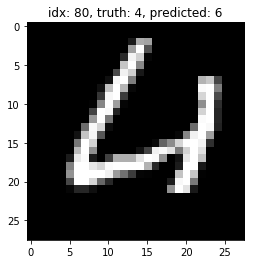

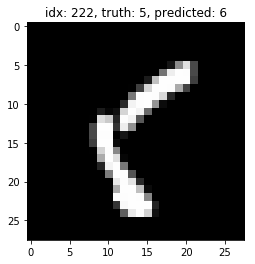

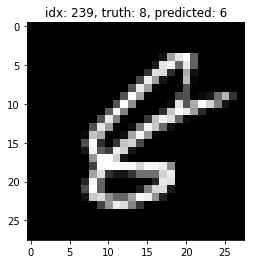

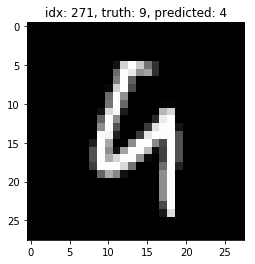

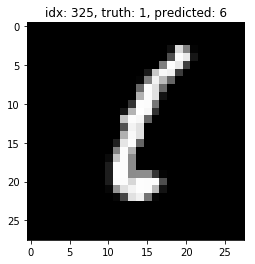

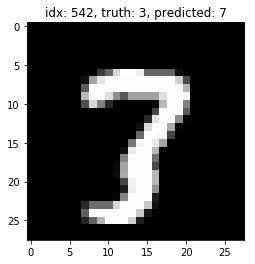

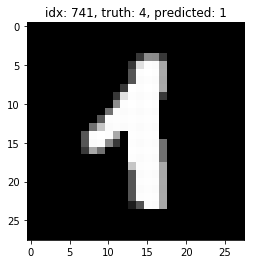

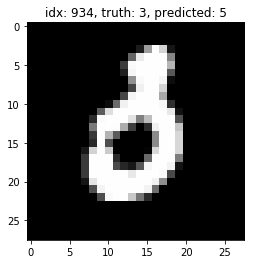

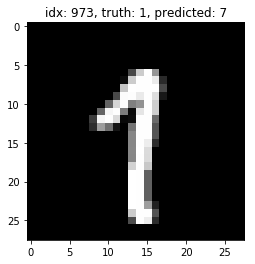

In [90]:
for idx in err_idx:
    pixels = X_test[idx].reshape((28, 28))
    plt.title('idx: ' + str(idx) + ', truth: ' + str(Y_test[idx]) + ', predicted: ' + str(Y_pred[idx]))
    plt.imshow(pixels, cmap=plt.cm.gray)
    plt.show()

In [91]:
def plot_confusion_matrix(y_actu, y_pred, title='Confusion matrix', cmap=plt.cm.gray):
    
    df_confusion = pd.crosstab(y_actu, y_pred.reshape(y_pred.shape[0],), rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    df_conf_norm = df_confusion / df_confusion.sum(axis=1)
    
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

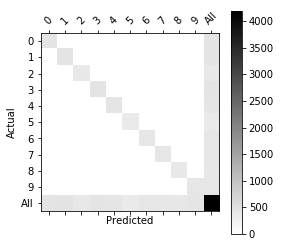

In [59]:
plot_confusion_matrix(Y_test, Y_pred)

## Submission

In [92]:
test = pd.read_csv('kg-data/test.csv', sep=',')
test.shape

X_test = test.values
X_test_len = len(X_test)
X_test = X_test.reshape((X_test_len, 28, 28, 1))

X_test.shape

(28000, 28, 28, 1)

In [93]:
Y_pred_oh = model.predict(X_test)
Y_pred = np.array([np.argmax(i) for i in Y_pred_oh])

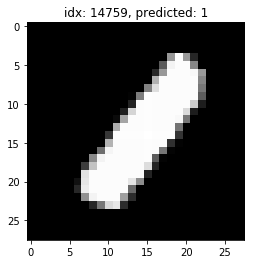

In [94]:
idx = np.random.randint(len(X_test))
pixels = X_test[idx].reshape((28, 28))
plt.title('idx: ' + str(idx) + ', predicted: ' + str(Y_pred[idx]))
plt.imshow(pixels, cmap=plt.cm.gray)
plt.show()

In [96]:
pred_df = pd.DataFrame(columns=['ImageId', 'Label'])
for i in range(len(Y_pred)):
    pred_df.loc[i] = (i+1, Y_pred[i])

In [97]:
pred_df[0:10]

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


In [98]:
pred_df.to_csv('kg-data/submission.csv', sep=',', index=False)